## Librerias

In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.set_option('display.float_format', '{:.3f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

## Clustering

### Preparación de los datos

In [4]:
#DATA FISLAC
dff = pd.read_csv("INPUT/FISLAC_update.csv")

# #POBLACIÓN
# pob = pd.read_excel("INPUT/POP_WB.xlsx")
# pob['DATE'] = pd.to_datetime(pob['DATE'], format='%Y')
# pob['POP'] = pd.to_numeric(pob['POP'], errors='coerce')
# pob.sort_values(by=['ISO3', 'DATE'], inplace=True)

# # pob['POP'].round(2).round(2).round(2).round(2).round(2).round(2) = pob.groupby('ISO3')['POP'].round(2).round(2).round(2).round(2).round(2).apply(lambda x: x.interpolate())
# # pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate().fillna(method='bfill').fillna(method='ffill'))

# pob['POP'] = pob.groupby('ISO3')['POP'.round(2).apply(lambda x: x.interpolate()).reset_index(level=0, drop=True)
# pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate().bfill().ffill()).reset_index(level=0, drop=True)

# pob['DATE'] = pob['DATE'].dt.year


# VARIABLES
variables = ["DEBT_GDP", "EXP_GDP", "REV_GDP","INTR_EXPENSES_GDP", "DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "CURR_EXP_GDP",
             "WGI_CONTR_CORR", "WGI_GOV_EFFECT", "WGI_POL_STAB", "WGI_REG_QUAL", "WGI_ROL", "WGI_VOICE_ACCOUNT",
             "TRADE_OPEN", "NET_FDI_GDP", "BROAD_MONEY_GDP", "INTRES_GDP",  "INFLATION",
             "LUR", "CAP_RETURN", "INT_RESERVES_CAP","BANK_CRISIS", "COMDEP",
             "CONSUMPTION_PC" ]

fr = ["FISCAL_RULE"]
ids = ["COUNTRY_NAME", "WEO_CODE", "ISO3" , "LAC1", "LAC2", "GROUP", "REGION", "DATE"]


#FILTRAR POR REGLAS FISCALES
df = dff[ids + variables + fr]

fr = df[["ISO3", "DATE", "FISCAL_RULE"]]
fr = fr[df.DATE>2000]
fr = fr.groupby(["ISO3"])["FISCAL_RULE"].sum().reset_index()
fr["FISCAL_RULE"] = fr["FISCAL_RULE"].apply(lambda x: 1 if x>0 else 0)

df = df[ids + variables]

df = df.merge(fr, "left", "ISO3")
df= df[df.FISCAL_RULE==1]

df = df[ids + variables]

# df = df.merge(pob, "left", ["DATE", "ISO3"])
grupos = df[["ISO3", "REGION", "GROUP", "COUNTRY_NAME"]].drop_duplicates()

### Parametros (paises tratados etc)

In [53]:
año_inferior = 2000
año_superior = 2005

# tratado = "PER"
tratado = "MEX"
# tratado = "GBR"

dfc = df[(df.DATE>=año_inferior) & (df.DATE<=año_superior)]
# dfc = dfc.groupby("ISO3").mean()

dfc = dfc.groupby(["ISO3"])[variables].mean()

# dfc = dfc[variables]

dfcm = dfc.copy()
dfcm = dfcm.merge(grupos, "left", "ISO3")

dfc = pd.DataFrame(scaler.fit_transform(dfc), columns=dfc.columns, index = dfc.index)


treated = dfcm[dfcm.ISO3 == tratado].T.reset_index()
treated.columns = ["VARIABLE", "MEDIA"]
maximo_mimebros = 20

In [54]:
os.makedirs(f'OUTPUT_{tratado}', exist_ok=True)

In [55]:
os.makedirs(f'OUTPUT_{tratado}/CLUSTERING', exist_ok=True)

### PCA

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(dfc)
df_principal = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'], index = dfc.index)

In [57]:
def plot_clusters(df_principal, save):
    fig, ax = plt.subplots(figsize=(5, 5))

    # if tratado == "PER":
    #     special_colors = {'PER': 'red', 'MEX': 'green', 'GBR': 'blue'}
    
    # if tratado == "MEX":
    #     special_colors = {'MEX': 'green', 'PER': 'red', 'GBR': 'blue'}

    # if tratado == "GBR":
    #     special_colors = {'GBR': 'blue', 'MEX': 'green', 'PER': 'red'}


    if tratado == "PER":
        special_colors = {'PER': '#0070C0'}
    
    if tratado == "MEX":
        special_colors = {'MEX': '#0070C0'}

    if tratado == "GBR":
        special_colors = {'GBR': '#0070C0'}


    color_map = {}
    used_colors = ['gray']*25

    color_iter = iter(used_colors)
    for cluster in df_principal['Cluster'].unique():
        found_special = False
        for special_index in special_colors:
            if special_index in df_principal[df_principal['Cluster'] == cluster].index:
                color_map[cluster] = special_colors[special_index]
                found_special = True
                break
        if not found_special:
            color_map[cluster] = next(color_iter)

    # Actualizar el DataFrame con los colores asignados
    df_principal['color'] = df_principal['Cluster'].map(color_map)

    # Dibujar texto y círculos para resaltar índices especiales
    for idx, row in df_principal.iterrows():
        if idx!=tratado:
            ax.text(row['PC1'], row['PC2'], idx, color=row['color'], ha='center', va='center', alpha = 0.3)
            if idx in special_colors:
                circle = Circle((row['PC1'], row['PC2']), 0.6, color=row['color'], fill=False, linewidth=2)
                ax.add_patch(circle)

        if idx==tratado:
            ax.text(row['PC1'], row['PC2'], idx, color=row['color'], ha='center', va='center', alpha = 1)
            if idx in special_colors:
                circle = Circle((row['PC1'], row['PC2']), 0.6, color=row['color'], fill=False, linewidth=2)
                ax.add_patch(circle)

        if df_principal.loc[idx]["color"] == df_principal.loc[tratado]["color"]:
            ax.text(row['PC1'], row['PC2'], idx, color=row['color'], ha='center', va='center', alpha = 0.5)
            if idx in special_colors:
                circle = Circle((row['PC1'], row['PC2']), 0.6, color=row['color'], fill=False, linewidth=2)
                ax.add_patch(circle)           

        # df_principal['Cluster']        

    ax.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    ax.axvline(0, color='gray', linestyle='dashed', linewidth=1)

    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])

    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')

    # ax.axis('off')  # Quitar los ejes si es necesario

    plt.savefig(save, dpi = 300, bbox_inches='tight')

    plt.show()

### Clustering jerárquico aglomerativo

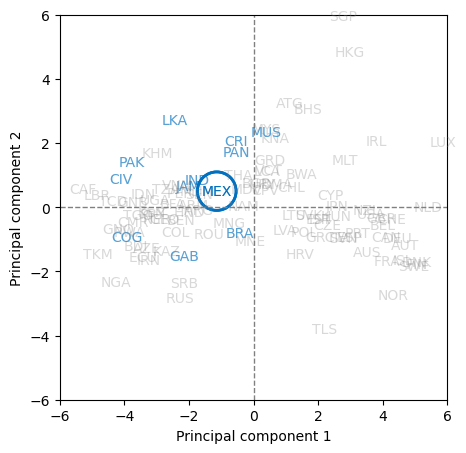

In [58]:
linked = linkage(dfc, method='ward')

from scipy.cluster.hierarchy import fcluster

for i in range(1,25):
    num_clusters = i
    clusters = fcluster(linked, num_clusters, criterion='maxclust')
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break

# dfcm = dfcm.select_dtypes(include=['number'])
jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()
jerarquico_media.columns = ["VARIABLE", "JERARQUICO"]

# jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); 
jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

jerarquico_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)
df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/0JERARQUICO.jpg')

### Clustering espectral

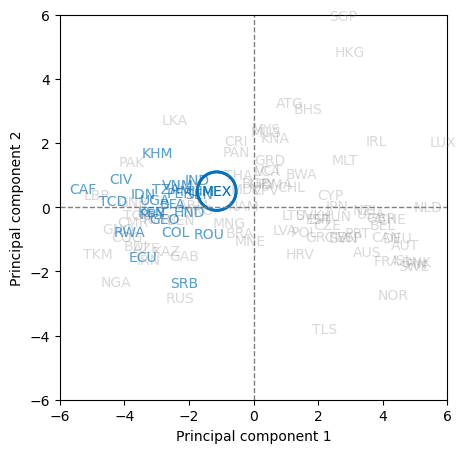

In [59]:
from sklearn.cluster import SpectralClustering

for i in range(5,25):

    num_clusters = i
    spectral = SpectralClustering(n_clusters= num_clusters, assign_labels='discretize',random_state=0).fit(dfc.values)
    clusters = spectral.fit_predict(dfc.values)
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


espectral_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()

jerarquico_media.columns = ["VARIABLE", "ESPECTRAL"]

jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/1ESPECTRAL.jpg')

### Clustering BIRCH

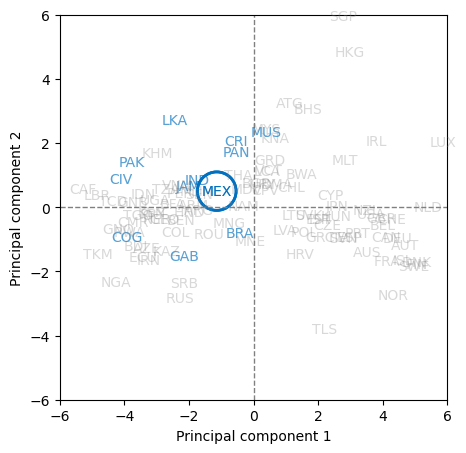

In [60]:
from sklearn.cluster import Birch


for i in range(1,25):

    birch = Birch(n_clusters=i)
    clusters = birch.fit_predict(dfc)
    clusters
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


birch_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()

jerarquico_media.columns = ["VARIABLE", "BIRCH"]
jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/2BIRCH.jpg')

### Clustering Kmeans

c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

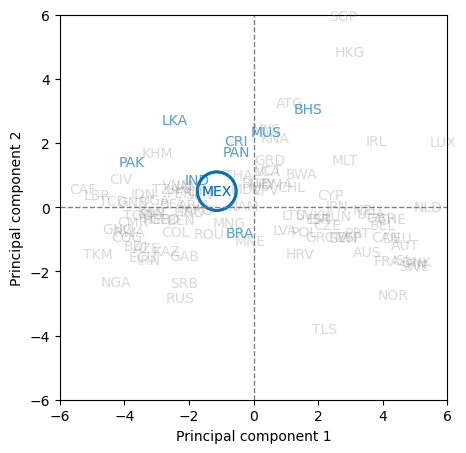

In [61]:
from sklearn.cluster import KMeans

# Suponemos que dfc es tu DataFrame y dfcm es otro DataFrame que incluye la columna 'ISO3'
maximo_miembros = 10  # Ajusta esto según el máximo de miembros deseado por cluster

for i in range(1, 25):
    num_clusters = i
    # Inicializar y ajustar KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(dfc)
    clusters = kmeans.labels_  # Obtener las etiquetas de los clusters directamente
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"] == tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros <= maximo_miembros:
        break

# Lista de códigos ISO3 de los miembros del cluster encontrado
kmean_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

# Calcular las medias para el cluster de interés
jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()
jerarquico_media.columns = ["VARIABLE", "KMEANS"]
jerarquico_media.loc[-1] = ["N", miembros]  # Agregar el número de miembros al DataFrame
jerarquico_media = jerarquico_media.sort_index().reset_index(drop=True)

# Integrar estos resultados en otro DataFrame si es necesario
treated = treated.merge(jerarquico_media, on="VARIABLE", how="outer")
df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/3KMEANS.jpg')


### Descriptivas

In [63]:
final_descr = treated.iloc[list(range(1,25))+[-1]]; final_descr = final_descr.rename(columns = {"MEDIA": tratado})
final_descr["MEDIA CLUSTERS"] = final_descr.iloc[:, 2:].T.mean()
final_descr = final_descr[['VARIABLE', tratado, 'MEDIA CLUSTERS', 'JERARQUICO', 'ESPECTRAL', 'BIRCH', 'KMEANS']]
final_descr.to_excel(f'OUTPUT_{tratado}/CLUSTERING/descriptive.xlsx')
final_descr

,VARIABLE,MEX,MEDIA CLUSTERS,JERARQUICO,ESPECTRAL,BIRCH,KMEANS
1,BROAD_MONEY_GDP,0.257,0.483,0.445,0.261,0.445,0.783
2,CAP_RETURN,0.126,0.149,0.147,0.123,0.147,0.181
3,COMDEP,0.128,0.240,0.288,0.302,0.288,0.081
4,CONSUMPTION_PC,12160.467,6309.351,6170.203,3517.157,6170.203,9379.842
5,COUNTRY_NAME,Mexico,NaN,NaN,NaN,NaN,NaN
6,CURR_EXP_GDP,0.148,0.145,0.150,0.126,0.150,0.153
7,DEBT_AFFORTABILITY,0.166,0.209,0.254,0.094,0.254,0.234
8,DEBT_GDP,0.408,0.649,0.740,0.536,0.740,0.582
9,EXP_GDP,0.213,0.222,0.233,0.202,0.233,0.221
10,GROUP,EMDEs,NaN,NaN,NaN,NaN,NaN


### Descriptivas: paises

In [64]:
lista_total = jerarquico_lista+espectral_lista+birch_lista+kmean_lista
cfrq = pd.DataFrame(index=pd.Series(lista_total).unique())

# Agregar las columnas para cada método y llenar con 0 o 1
cfrq['Jerarquico'] = [1 if x in jerarquico_lista else 0 for x in cfrq.index]
cfrq['Espectral'] = [1 if x in espectral_lista else 0 for x in cfrq.index]
cfrq['Birch'] = [1 if x in birch_lista else 0 for x in cfrq.index]
cfrq['KMeans'] = [1 if x in kmean_lista else 0 for x in cfrq.index]
cfrq["Total"] = cfrq.T.sum()
cfrq = cfrq.sort_values("Total", ascending = False)
cfrq = cfrq.reset_index(); cfrq = cfrq.rename(columns = {"index": "ISO3"})
paises = dff[["ISO3", "COUNTRY_NAME"]].drop_duplicates()
cfrq = cfrq.merge(paises, "left", "ISO3")
cfrq = cfrq[cfrq.ISO3!=tratado]

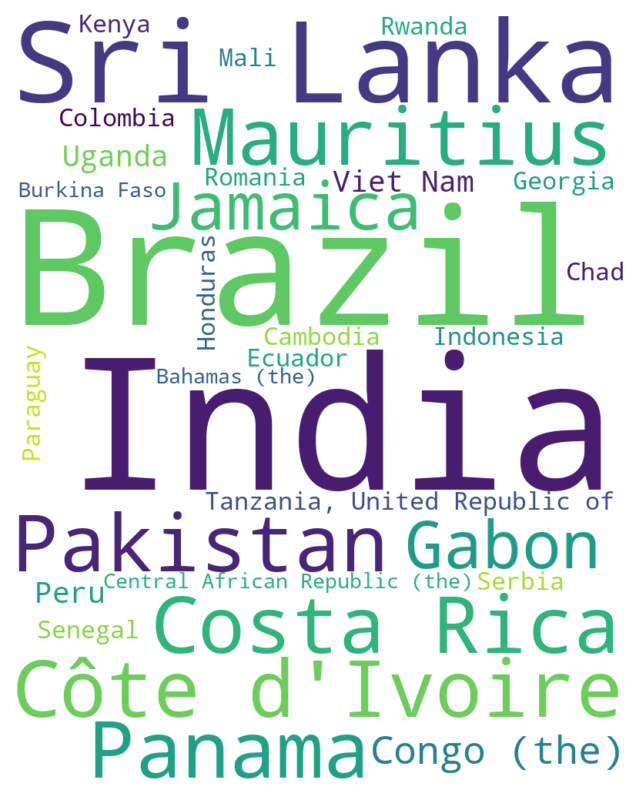

In [65]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=1000, background_color='white').generate_from_frequencies(dict(zip(cfrq['COUNTRY_NAME'], cfrq['Total'])))

# Mostrar la nube de palabras
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(f'OUTPUT_{tratado}/CLUSTERING/WORDCLOUD.jpg', dpi = 300, bbox_inches='tight')
plt.show()


In [54]:
clusterdf = cfrq[["ISO3", "Total"]]; clusterdf.columns = ["ISO3", "CLUSTER"]
df = df.merge(clusterdf, "left", "ISO3")
df["CLUSTER"] = df["CLUSTER"].fillna(0)

In [55]:
df.to_csv(f"{tratado}_DB.csv", index = False)

# Run synthetic control

## Parametros

In [54]:
# Load Data 
# --------------------------------------------------------------------------
tratado = "GBR"
pais = "GBR"

muestra = "EUR"
# muestra  = "CLU"
# muestra = "CLU&EUR"


# tratado = "MEX"
# pais = "MEX"

# tratado = "PER"
# pais = "PER"

# muestra = "LAC"
# muestra  = "CLU"
# muestra = "CLU&LAC"

df = pd.read_csv(f"{tratado}_DB.csv")

# --------------------------------------------------------------------------

# year_t0 = 1995 #AÑO AL INICIO

year_t0 = 2000 #AÑO AL INICIO
year_t1 = 2008 #AÑO DEL TRATAMIENTO
year_t2 = year_t1 + 6 #AÑO FINAL

df = pd.read_csv(f"{tratado}_DB.csv")

d = df[df.DATE<=year_t2]
d = d[d.DATE>=year_t0]

code_treated = d[d.ISO3==pais]["WEO_CODE"].iloc[0]

# --------------------------------------------------------------------------
if pais == "PER":

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 2) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------     

if (pais == "MEX") | (pais == "PAN"):

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 2) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 2) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------

# paises_uk = [pais, "USA", "AUS", "GEO", "IRL", "NLD", "GEO"]
# d = d[d['ISO3'].isin(paises_uk)]

if tratado == "GBR":

    region = df[df.ISO3=="GBR"].REGION.iloc[0]

    if muestra == "EUR":
        d = d[d['REGION'] == region]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&EUR":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['REGION'] == region) | (d['WEO_CODE'] == code_treated))]

os.makedirs(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}', exist_ok=True) 

In [55]:
#################################################################################
# PARAMETERS
#################################################################################

# predictors_dp       = ["DEBT_GDP"]
predictors_dp       = ["DEBT_GDP","EXP_GDP", "INTRES_GDP"]
dependent_dp        = "DEBT_GDP"
id_variable         = "WEO_CODE"
time_variable       = "DATE"

special_predictors = None

special_predictors  = [("REV_GDP", range(year_t0,year_t1), "mean"),
                           ("TRADE_OPEN", range(year_t0,year_t1), "mean"),
                            ("NET_FDI_GDP", range(year_t0,year_t1), "mean"),
                            ("LUR", range(year_t0,year_t1), "mean"),
                            ("CAP_RETURN", range(year_t0,year_t1), "mean"),
                            ("INFLATION", range(year_t0,year_t1), "mean")]



treated             = code_treated 
controls            = list(set(d['WEO_CODE'].unique()) - set([treated]))
time_predictors     = range(year_t0,year_t1)
time_ssr            = range(year_t0,year_t1)

#################################################################################
# DATA PREPARATION
#################################################################################


dataprep = Dataprep(
           foo = d,
           predictors    = predictors_dp,
           predictors_op="mean",
           dependent     = dependent_dp,
           unit_variable = id_variable,
           time_variable = time_variable,
           special_predictors = special_predictors,
           treatment_identifier = treated,
           controls_identifier = controls,
           time_predictors_prior = time_predictors,
           time_optimize_ssr = time_ssr)

# #################################################################################
# print(dataprep)
# #################################################################################
# A = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "trust-constr"]
# A = ["Powell", "COBYLA"]
# resultados = {}

# for metodo in A:
#     synth = Synth()
#     synth.fit(dataprep=dataprep, optim_method=metodo, optim_initial="ols")
#     print(metodo)
#     synth.path_plot(time_period=range(year_t0, year_t2), treatment_time=year_t1)
#     mae = synth.mae()
#     mse = synth.mspe()
#     resultados[metodo] = {'MAE': mae, 'MSE': mse}

# metodo_optimo = min(resultados, key=lambda x: resultados[x]['MSE'])
# synth.fit(dataprep=dataprep, optim_method=metodo_optimo, optim_initial="ols")

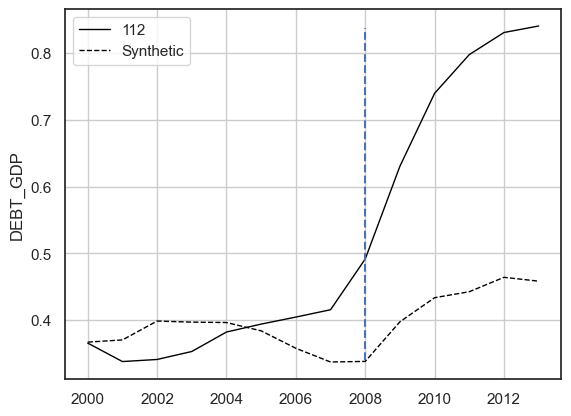

In [56]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="COBYLA", optim_initial="ols")
synth.path_plot(time_period=range(year_t0, year_t2), treatment_time=year_t1)

## Variables

In [57]:
# Crear un objeto ExcelWriter
tablas = pd.ExcelWriter(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/Tablas.xlsx')

In [58]:
variables = synth.summary().round(3)
variables.columns = ["Weight", pais, f"{pais} Synth", "Sample Mean"]
variables.to_excel(tablas, sheet_name='Variables')
variables

,Weight,GBR,GBR Synth,Sample Mean
DEBT_GDP,0.189,0.374,0.376,0.458
EXP_GDP,0.278,0.368,0.367,0.392
INTRES_GDP,0.001,0.027,0.163,0.141
special.1.REV_GDP,0.262,0.349,0.350,0.388
special.2.TRADE_OPEN,0.001,0.524,0.994,0.930
special.3.NET_FDI_GDP,0.000,0.255,-0.002,-0.199
special.4.LUR,0.004,0.051,0.072,0.097
special.5.CAP_RETURN,0.001,0.099,0.056,0.073
special.6.INFLATION,0.264,0.016,0.017,0.052


## Countries

In [59]:
# UK
# Country	Weight
# 33	Australia	0.433
# 45	United States of America (the)	0.325
# 4	Netherlands (the)	0.23

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15844\3723473148.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_yticklabels(labels=filtered_countries['Country'], fontsize=10)


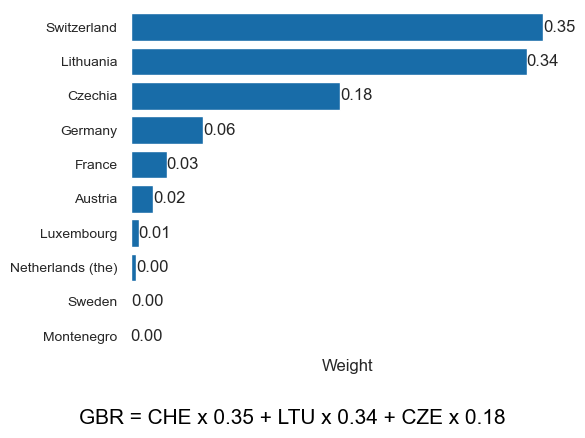

In [60]:
countries = d[["ISO3", "WEO_CODE", "COUNTRY_NAME"]].drop_duplicates()
countriesw = pd.DataFrame(zip(controls,synth.W)); countriesw.columns = ["WEO_CODE", "Weight"]
countries = countries.merge(countriesw, "right", "WEO_CODE")
countries = countries[["ISO3", "COUNTRY_NAME", "Weight"]]
countries.columns = ["ISO3", "Country", "Weight"]
countries = countries.sort_values(by = "Weight", ascending=False)
countries.to_excel(tablas, sheet_name='Donors Countries')

filtered_countriesq = countries[countries['Weight'] > 0.1]
filtered_countries = countries.iloc[0:10]

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Weight', y='Country', data=filtered_countries, color='#0070C0')
barplot.set_yticklabels(labels=filtered_countries['Country'], fontsize=10)
barplot.bar_label(barplot.containers[0], fmt='%.2f')
plt.xticks([])
plt.ylabel("")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
equation_parts = [f"{row['ISO3']} x {row['Weight']:.2f}" for index, row in filtered_countriesq.iterrows()]
equation_text = f"{tratado} = " + " + ".join(equation_parts)
plt.figtext(0.5, -0.08, equation_text, wrap=True, horizontalalignment='center', fontsize=15, color='black')
plt.tight_layout()
plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/0COUNTRIES.jpg', dpi = 300, bbox_inches='tight')
plt.show()

In [61]:
len(countries)

37

## Effects

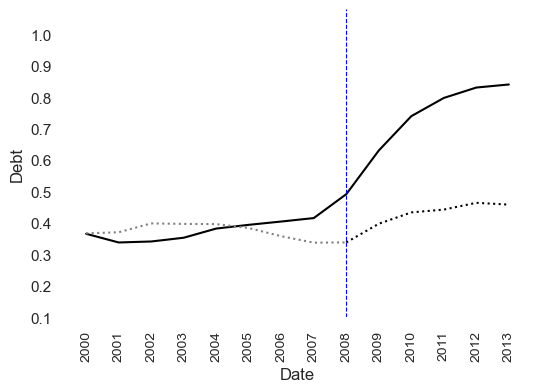

In [62]:
Z0, Z1   = dataprep.make_outcome_mats(time_period=range(year_t0, year_t2))
y_synth  = (Z0 * synth.W).sum(axis = 1)
y_actual = Z1
y_sample = Z0.T.mean()
effect    = y_actual - y_synth 
treat_year = fila = np.where(np.arange(year_t0, year_t2 + 1) == year_t1, 1, 0)
efecto = pd.DataFrame(zip(y_sample, y_actual, y_synth, effect, treat_year),
                      columns = ["Sample Mean", pais,f"{pais} Synth", "Effect", "Tyear"])
efecto.index = y_sample.index; efecto = efecto.reset_index(drop = False)
efecto.to_excel(tablas, sheet_name='Efecto')

# efecto = efecto[efecto.DATE>=2000]

plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y=pais, color='black', label=None)
sns.lineplot(data=efecto[efecto['DATE'] <= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='gray', label=None)
sns.lineplot(data=efecto[efecto['DATE'] >= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

stdp = (efecto[pais].std()*1.2)
minp = round(efecto[pais].min() - stdp, 2)
# minp = 0
maxp = round(efecto[pais].max() + stdp, 2)
plt.ylim(minp,maxp)
plt.yticks(np.arange(minp,maxp, 0.10))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1, color='blue', linestyle='dashed', linewidth=0.8)
plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/1SYNTH.jpg', dpi = 300, bbox_inches='tight')

plt.show()

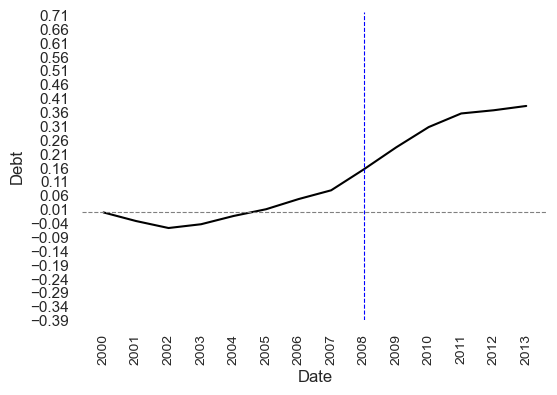

In [63]:
plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y="Effect", color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

stdp = (efecto["Effect"].std()*2)
minp = round(efecto["Effect"].min() - stdp,2)
maxp = round(efecto["Effect"].max() + stdp,2)

plt.ylim(minp,maxp)
plt.yticks(np.arange(minp,maxp, 0.05))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1, color='blue', linestyle='dashed', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.8)

plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/2EFFECT.jpg', dpi = 300, bbox_inches='tight')

plt.show()

## Placebo

In [46]:
countries = d[["ISO3", "WEO_CODE", "COUNTRY_NAME"]].drop_duplicates()
countriesw = pd.DataFrame(zip(controls,synth.W)); countriesw.columns = ["WEO_CODE", "Weight"]
countries = countries.merge(countriesw, "right", "WEO_CODE")
placebos = dict(zip(countries.WEO_CODE, countries.ISO3))
placebos[code_treated] = pais

In [188]:
from tqdm import tqdm as tq

In [117]:
placdf = pd.DataFrame(columns = ["ISO3", "PRE", "POST", "POST/PRE", "TREATED"])
for co in tq(list(placebos.keys())[0:]):
    
    treated = co 
    controls = list(set(d['WEO_CODE'].unique()) - set([treated]))
    
    dataprep = Dataprep(
           foo = d,
           predictors    = predictors_dp,
           predictors_op="mean",
           dependent     = dependent_dp,
           unit_variable = id_variable,
           time_variable = time_variable,
           special_predictors = special_predictors,
           treatment_identifier = treated,
           controls_identifier = controls,
           time_predictors_prior = time_predictors,
           time_optimize_ssr = time_ssr)
    
    paisp = placebos[co]
    
    synth.fit(dataprep=dataprep, optim_method="COBYLA", optim_initial="ols")
    Z0, Z1   = dataprep.make_outcome_mats(time_period=range(year_t0, year_t2))
    y_synth  = (Z0 * synth.W).sum(axis = 1)
    y_actual = Z1
    y_sample = Z0.T.mean()
    effect    = y_actual - y_synth 
    treat_year = fila = np.where(np.arange(year_t0, year_t2 + 1) == year_t1, 1, 0)
    efecto = pd.DataFrame(zip(y_sample, y_actual, y_synth, effect, treat_year),
                          columns = ["Sample Mean", paisp,f"{paisp} Synth", "Effect", "Tyear"])
    efecto.index = y_sample.index; efecto = efecto.reset_index(drop = False)    
    
    pre = efecto[efecto.DATE<year_t1]["Effect"]; pre = np.sqrt((pre**2).sum()/len(pre))
    post = efecto[efecto.DATE>=year_t1]["Effect"]; post =  np.sqrt((post**2).sum()/len(post))

    t = 0
    if paisp == pais:
        t = 1
    
    placdf.loc[len(placdf)] = {
    "ISO3": paisp,
    "PRE": pre,
    "POST": post,
    "POST/PRE": post/pre,
    "TREATED": t
}
    

100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


In [118]:
A = placdf.groupby("TREATED")[["PRE", "POST", "POST/PRE"]].mean().sort_index(ascending=False)
pre = A["PRE"]; pos = A["POST"]; pospre = A["POST/PRE"]
B = pd.concat([pre, pos, pospre]).reset_index()
B.TREATED = ["Treated", "Controls"]*3
B.index = ["RMSE PRE", "", "RMSE POST", "", "POST/PRE", ""]
B.columns = ["TREATED", pais]
plcsort = placdf.sort_values(by = "POST/PRE").reset_index(drop = True)
rank = f"{plcsort[plcsort.ISO3 == pais].index[0]}/{len(plcsort)}"
B.loc["RANK"] = ["Treated", rank]


B.to_excel(tablas, sheet_name='Placebos')

B

,TREATED,MEX
RMSE PRE,Treated,0.023
,Controls,0.118
RMSE POST,Treated,0.071
,Controls,0.095
POST/PRE,Treated,3.006
,Controls,1.358
RANK,Treated,11/14


In [119]:
tablas.close()

# Recopilación de gráficas y tablas

In [65]:
ff = f'FIGURAS&TABLAS/'
os.makedirs(ff, exist_ok=True)

In [66]:
paths = ["MEX_2016_LAC", "PER_2010_LAC", "GBR_2008_CLU"]

tablainicial = pd.DataFrame()

for i,path in enumerate(paths):
    pais  = path.split("_")[0]
    tabla = pd.read_excel(f"OUTPUT_{pais}/{path}/Tablas.xlsx", sheet_name="Placebos")

    if i>0:
        tabla = tabla.drop(columns = ["Unnamed: 0", "TREATED"])

    tablainicial = pd.concat([tablainicial, tabla], axis = 1)

In [67]:
tabla_inicial = tablainicial.copy()

ultima_fila = tabla_inicial.iloc[-1:].copy()

# Tomar el resto del DataFrame sin la última fila
tabla_sin_ultima = tabla_inicial.iloc[:-1].copy()

# Redondear solo las columnas numéricas en el DataFrame sin la última fila
tabla_sin_ultima = tabla_sin_ultima.round(2)
tabla_sin_ultima["MEX"] = tabla_sin_ultima["MEX"].apply(lambda x: float(int(x * 100)) / 100 if isinstance(x, (int, float)) else x)
tabla_sin_ultima["PER"] = tabla_sin_ultima["PER"].apply(lambda x: float(int(x * 100)) / 100 if isinstance(x, (int, float)) else x)
tabla_sin_ultima["GBR"] = tabla_sin_ultima["GBR"].apply(lambda x: float(int(x * 100)) / 100 if isinstance(x, (int, float)) else x)

# tabla_sin_ultima["MEX"] = tabla_sin_ultima["MEX"].round(2)


# Unir el DataFrame redondeado con la última fila
tablainicial = pd.concat([tabla_sin_ultima, ultima_fila])


# Truncar los valores numéricos a dos decimales
# Convertir a LaTeX
latex_table = f"""
\\begin{{table}}[H]
   \\centering
   \\caption{{STATUS}}
   \\begin{{tabular}}{{lcccc}}
   \\hline
   & STATUS & MEX & PER & GBR \\\\
   \\hline
   \\multirow{{2}}{{*}}{{\\centering RMSE PRE}}  & Treated  & {tablainicial.iloc[0, 2]} & {tablainicial.iloc[0, 3]} & {tablainicial.iloc[0, 4]} \\\\
                                         & Controls & {tablainicial.iloc[1, 2]} & {tablainicial.iloc[1, 3]} & {tablainicial.iloc[1, 4]} \\\\
   \\hline
   \\multirow{{2}}{{*}}{{\\centering RMSE POST}} & Treated  & {tablainicial.iloc[2, 2]} & {tablainicial.iloc[2, 3]} & {tablainicial.iloc[2, 4]} \\\\
                                         & Controls & {tablainicial.iloc[3, 2]} & {tablainicial.iloc[3, 3]} & {tablainicial.iloc[3, 4]} \\\\
   \\hline
   \\multirow{{2}}{{*}}{{\\centering POST/PRE}}  & Treated  & {tablainicial.iloc[4, 2]} & {tablainicial.iloc[4, 3]} & {tablainicial.iloc[4, 4]} \\\\
                                         & Controls & {tablainicial.iloc[5, 2]} & {tablainicial.iloc[5, 3]} & {tablainicial.iloc[5, 4]} \\\\
   \\hline
   RANK                                  & Treated  & {tablainicial.iloc[6, 2]} & {tablainicial.iloc[6, 3]} & {tablainicial.iloc[6, 4]} \\\\
   \\hline
   \\end{{tabular}}
\\end{{table}}
"""

In [68]:
open(f'{ff}/0 Table RMSE.tex', 'w').write(latex_table)

732

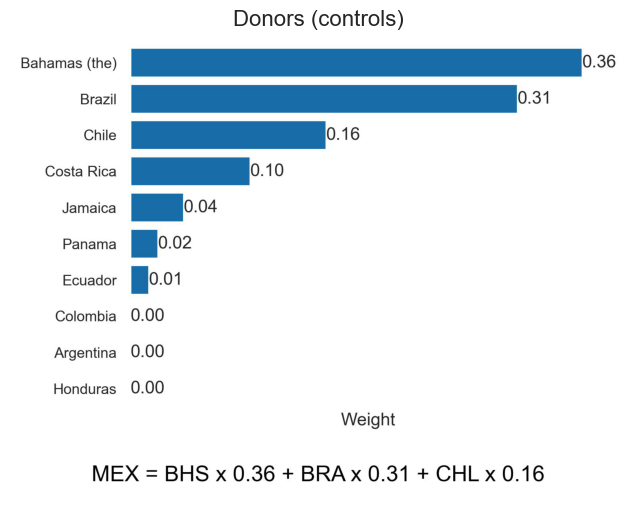

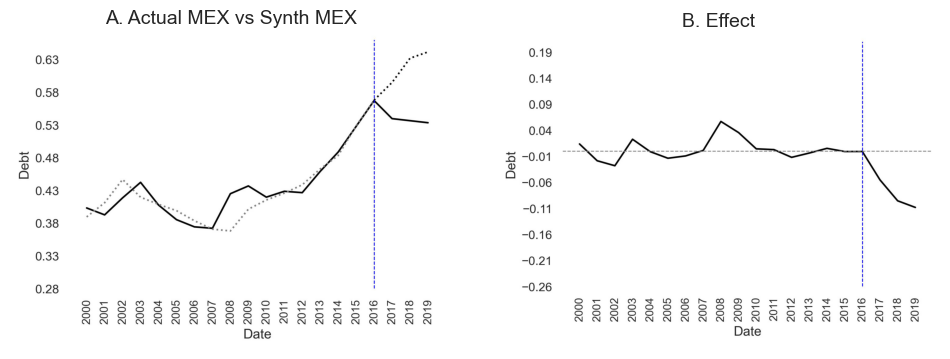

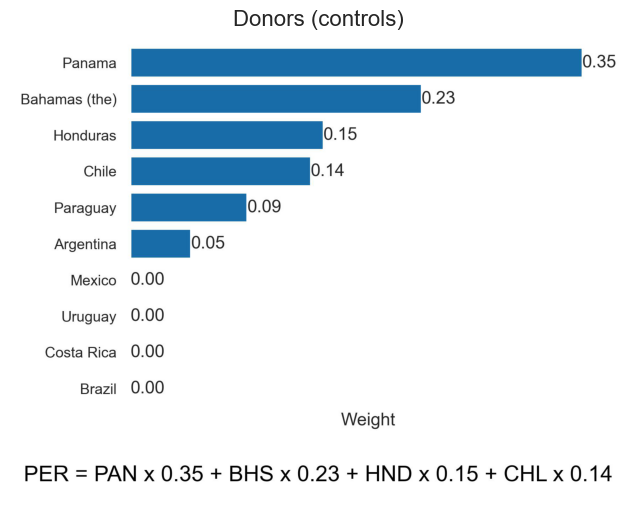

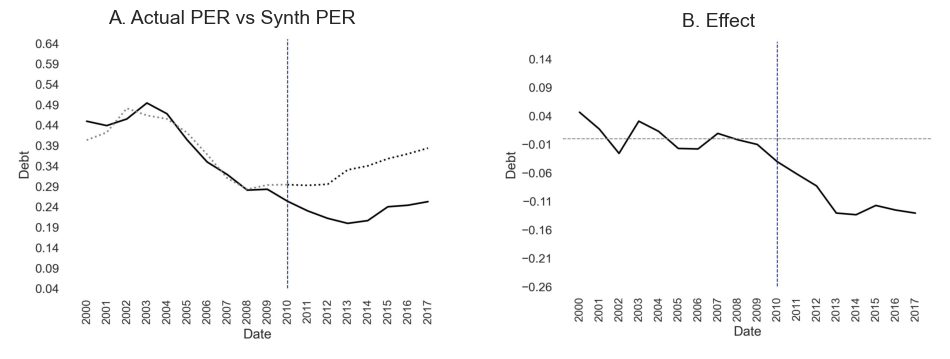

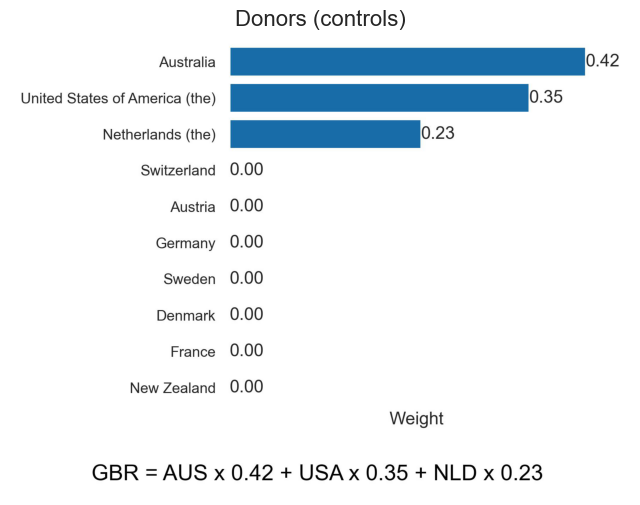

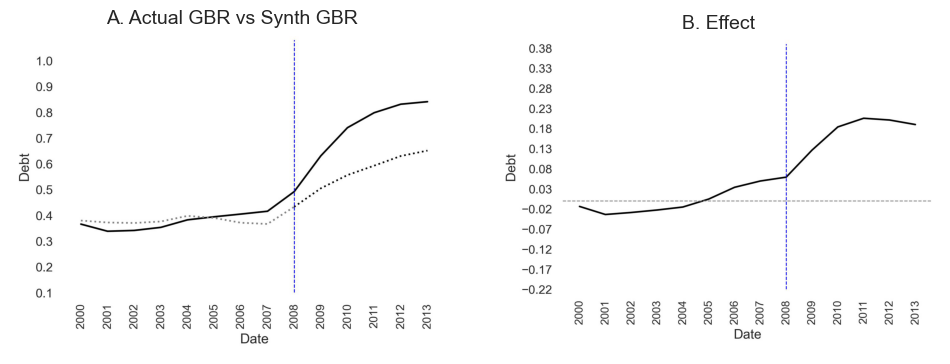

In [75]:
import matplotlib.image as mpimg

path_im = "MEX_2016_LAC"

for i,path in enumerate(paths[:]):

    pais  = path.split("_")[0]

    #########################################################################################
    image_path_1 = f"OUTPUT_{pais}/{path}/0COUNTRIES.jpg"

    img = mpimg.imread(image_path_1)

    fig, ax = plt.subplots(figsize=(8, 6))  # Puedes ajustar el tamaño con figsize

    # Mostrar la imagen
    ax.imshow(img)

    # Opcional: Personalizar la imagen
    ax.axis('off')  # Quitar los ejes si es necesario
    ax.set_title("Donors (controls)", fontsize=16)  # Título modificable

    plt.savefig(f'{ff}/{i}_{pais}_2_DONORS.jpg', dpi = 300, bbox_inches='tight')

    #########################################################################################
    image_path_1 = f"OUTPUT_{pais}/{path}/1SYNTH.jpg"
    image_path_2 = f"OUTPUT_{pais}/{path}/2EFFECT.jpg"

    # Cargar las imágenes
    img1 = mpimg.imread(image_path_1)
    img2 = mpimg.imread(image_path_2)

    # Crear la figura y los ejes con un layout de 1x2
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas, tamaño ajustable

    # Mostrar la primera imagen en el primer eje
    ax[0].imshow(img1)
    ax[0].axis('off')  # Opcional: Quitar los ejes si es necesario
    ax[0].set_title(f"A. Actual {pais} vs Synth {pais}", fontsize=14)  # Título modificable

    # Mostrar la segunda imagen en el segundo eje
    ax[1].imshow(img2)
    ax[1].axis('off')  # Opcional: Quitar los ejes si es necesario
    ax[1].set_title("B. Effect", fontsize=14)  # Título modificable

    # Ajustar la separación entre imágenes
    plt.subplots_adjust(wspace=0.1)  # Cambia wspace para modificar la separación horizontal

    plt.savefig(f'{ff}/{i}_{pais}_3_SYNTH_EFFECT.jpg', dpi = 300, bbox_inches='tight')

    # Mostrar la figura
    plt.show()

    

    ########################################################################################

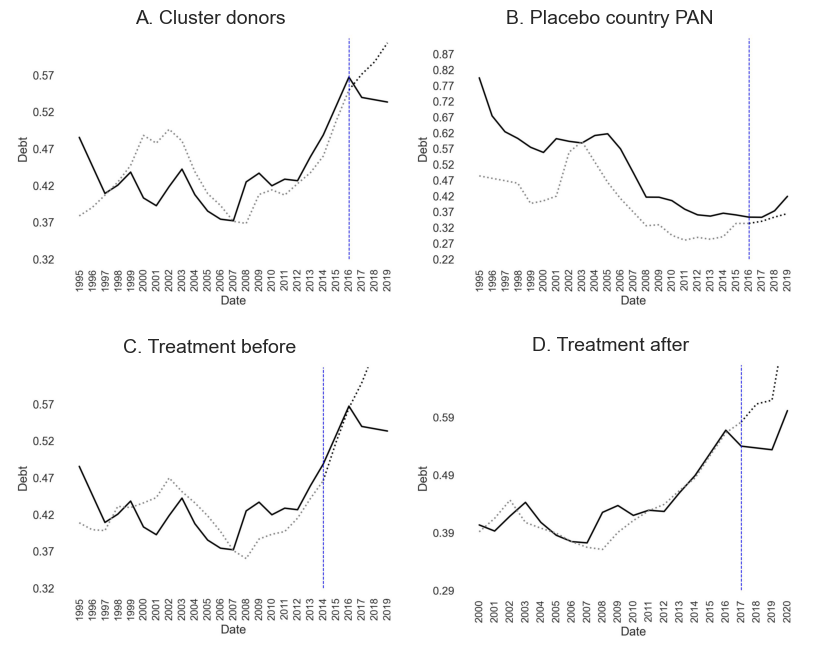

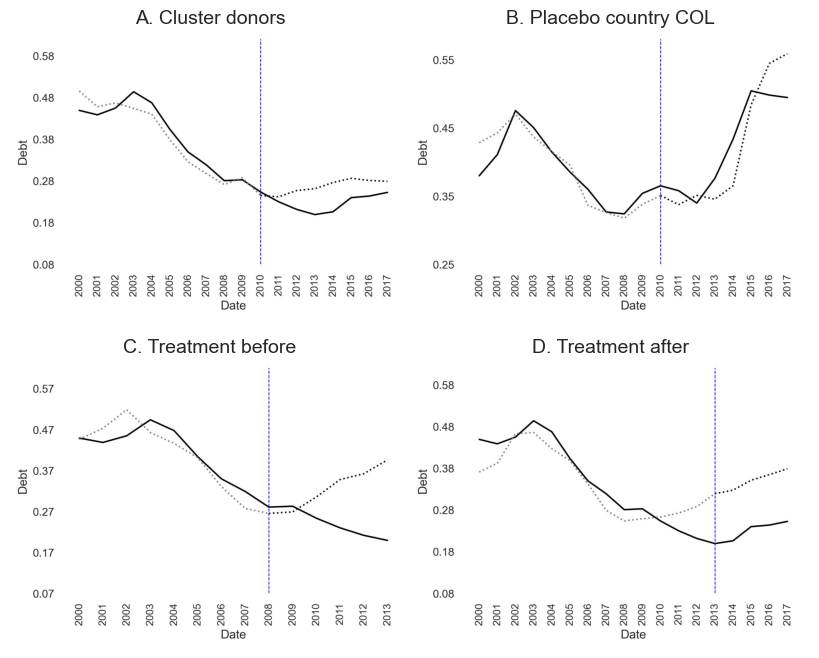

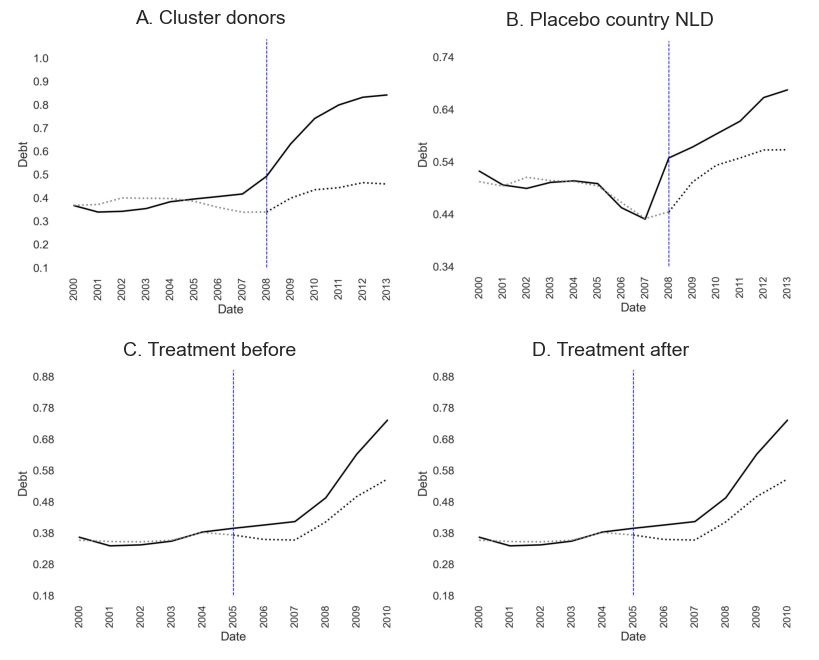

In [76]:
import matplotlib.image as mpimg

# path_im = "MEX_2016_LAC"

mex = ["MEX_2016_CLU", "PAN_2016_LAC", "MEX_2014_LAC", "MEX_2017_LAC"]
per = ["PER_2010_CLU", "COL_2010_LAC", "PER_2008_LAC", "PER_2013_LAC"]
gbr = ["GBR_2008_EUR", "NLD_2008_CLU", "GBR_2005_CLU", "GBR_2005_CLU"]

rob = [mex, per, gbr]

for (i,path), p in zip(enumerate(paths[:]), rob[:]):

    pais  = path.split("_")[0]

    ruta1 = f"OUTPUT_{pais}/{p[0]}/1SYNTH.jpg"
    ruta2 = f"OUTPUT_{pais}/{p[1]}/1SYNTH.jpg"
    ruta3 = f"OUTPUT_{pais}/{p[2]}/1SYNTH.jpg"
    ruta4 = f"OUTPUT_{pais}/{p[3]}/1SYNTH.jpg"

    country_placebo = p[1].split("_")[0]

    # #########################################################################################
    # # Rutas de las imágenes
    image_paths = [ruta1, ruta2, ruta3, ruta4]

    # Crear la figura y los ejes con un layout de 2x2
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))  # 2 filas, 2 columnas

    # Mostrar cada imagen en su respectivo subplot
    ax[0, 0].imshow(mpimg.imread(image_paths[0]))
    ax[0, 0].axis('off')
    ax[0, 0].set_title("A. Cluster donors", fontsize=14)

    ax[0, 1].imshow(mpimg.imread(image_paths[1]))
    ax[0, 1].axis('off')
    ax[0, 1].set_title(f"B. Placebo country {country_placebo}", fontsize=14)

    ax[1, 0].imshow(mpimg.imread(image_paths[2]))
    ax[1, 0].axis('off')
    ax[1, 0].set_title("C. Treatment before", fontsize=14)

    ax[1, 1].imshow(mpimg.imread(image_paths[3]))
    ax[1, 1].axis('off')
    ax[1, 1].set_title("D. Treatment after", fontsize=14)

    # Ajustar el espacio entre las imágenes de arriba y abajo
    # plt.subplots_adjust(wspace=0, hspace=0)  # hspace más pequeño para reducir la separación vertical
    plt.subplots_adjust(wspace=0, hspace=-0.3, left=0, right=1, top=1, bottom=0)

    plt.savefig(f'{ff}/{i}_{pais}_4_ROBUSTNESS.jpg', dpi = 300, bbox_inches='tight')



    # Mostrar la figura
    plt.show()